# Variational autoencoder

The variational autoencoder should be able to identify abnormal heartbeat patterns.

In [1]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import gin
from streamer import VAEstreamer
import rae_model
from loguru import logger
import numpy as np
import sys
import datasets, metrics
import mltrainer
from mltrainer import ReportTypes, Trainer, TrainerSettings


In [2]:
# use the binary data for training the Variational Autoencoder
trainfileVAE = Path('../data/heart_train.parq').resolve()
testfileVAE = Path('../data/heart_test.parq').resolve()
validationfileVAE = Path('../data/heart_test.parq').resolve()

# Remove outliers for training the VAE
traindatasetVAE = datasets.HeartDataset1D(trainfileVAE, target="target", outliersRemoval=True)
testdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=True)

#  Keep outliers for validation and finding a appropriate reconstructionloss
validsdatasetVAE = datasets.HeartDataset1D(testfileVAE, target="target", outliersRemoval=False)

trainstreamerVAE = VAEstreamer(traindatasetVAE, batchsize=32).stream()
teststreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()
validstreamerVAE = VAEstreamer(testdatasetVAE, batchsize=32).stream()

Training the Autoencoder is really hard, because it could reconstruct a lot of abnormal samples with a reconstruction loss as small as with the normal samples.
Therefore some comparison is made

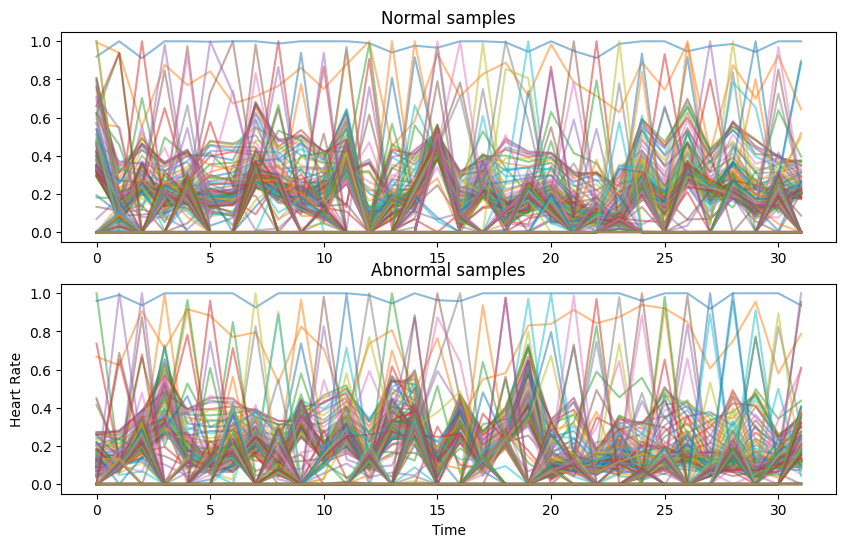

In [3]:
import matplotlib.pyplot as plt

# Initialize a plot
fig = plt.figure(figsize=(10, 6))

XN, X2 = next(trainstreamerVAE)
XA, X2 = next(validstreamerVAE)

XN = XN.view(XN.size(0), -1) 
XA = XA.view(XA.size(0), -1) 

ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(XN, alpha=0.5)
ax1.set_title('Normal samples')

ax2.plot(XA, alpha=0.5)
ax2.set_title('Abnormal samples')


plt.xlabel('Time')
plt.ylabel('Heart Rate')

# Show plot
plt.show()

In [4]:
X1, X2 = next(trainstreamerVAE)

encoder = rae_model.Encoder()
decoder = rae_model.Decoder()

logger.info(f"the shape before : {X1.shape}")

latent = encoder(X1)
logger.info(f"the latent shape : {latent.shape}")

x = decoder(latent)
logger.info(f"the shape after: {x.shape}")

lossfn = rae_model.ReconstructionLoss()
loss = lossfn(x, X2)
logger.info(f"Untrained loss: {loss}")

logger.info(f"starting training for {200} epochs")
autoencoder = rae_model.RecurrentAutoencoder()

settings = TrainerSettings(
    epochs=25,
    metrics=[lossfn],
    logdir="logs",
    train_steps=25,
    valid_steps=25,
    reporttypes=[ReportTypes.TENSORBOARD],
    earlystop_kwargs = {
        "save": False,
        "verbose": True,
        "patience": 8,
    },
    scheduler_kwargs={"factor": 0.1, "patience": 5},
)

trainer = Trainer(
    model=autoencoder,
    settings=settings,
    loss_fn=lossfn,
    optimizer=torch.optim.Adam,
    traindataloader=trainstreamerVAE,
    validdataloader=teststreamerVAE,
    scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
)
trainer.loop()

2024-06-24 20:38:26.132 | INFO     | __main__:<module>:6 - the shape before : torch.Size([32, 192, 1])
2024-06-24 20:38:26.245 | INFO     | __main__:<module>:9 - the latent shape : torch.Size([32, 64])
2024-06-24 20:38:26.263 | INFO     | __main__:<module>:12 - the shape after: torch.Size([32, 192, 1])
2024-06-24 20:38:26.265 | INFO     | __main__:<module>:16 - Untrained loss: 7.309675693511963
2024-06-24 20:38:26.266 | INFO     | __main__:<module>:18 - starting training for 200 epochs
2024-06-24 20:38:26.286 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/20240624-203826
2024-06-24 20:38:26.710 | INFO     | mltrainer.trainer:__init__:72 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:02<00:00,  8.72it/s]
2024-06-24 20:38:30.555 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 4.6118 test 3.5771 metric ['3.5771']
100%|██████████| 25/25 [00:02<00:00,  9.70it/s]
2024-06-24 20:38:34.128 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 3.4453 test 3.0874 metric ['3.0874']
100%|██████████| 25/25 [00:02<00:00,  9.84it/s]
2024-06-24 20:38:37.663 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 2.4716 test 2.0800 metric ['2.0800']
100%|██████████| 25/25 [00:02<00:00, 10.35it/s]
2024-06-24 20:38:41.042 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 1.9201 test 1.7803 metric ['1.7803']
100%|██████████| 25/25 [00:02<00:00, 10.10it/s]
2024-06-24 20:38:44.533 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 1.6951 test 1.6557 metric ['1.6557']
100%|██████████| 25/25 [00:02<00:00, 10.72it/s]
2024-06-24 20:38:47.854 | INFO     | mltrainer.trainer:report:191 - Epoch 5 train 1.5915 test 1.4645 metric ['1.4645'

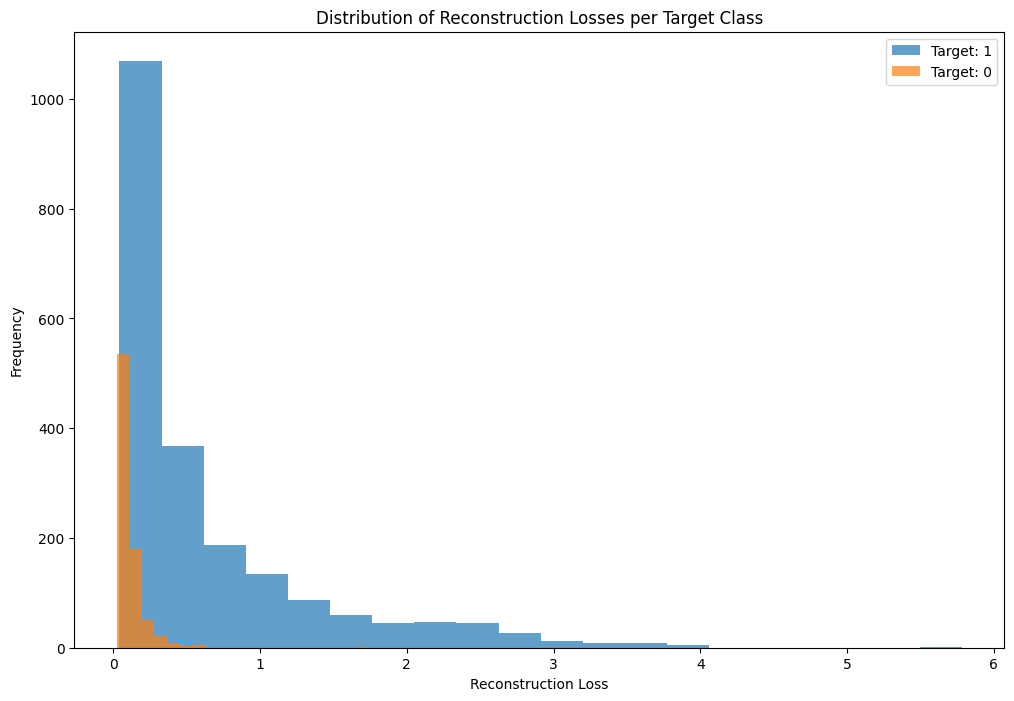

In [5]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    with torch.no_grad():
        autoencoder.eval()

        for input_sequence, target in dataset:
            # Ensure input_sequence has correct dimensions (batch_size, seq_len, n_features)
            input_sequence = input_sequence.unsqueeze(0).to(device)  # Add a dummy batch dimension

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))  # Use input_sequence for calculating loss
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_losses_per_target(dataset, encoder, decoder):
    losses_per_target = {}

    # Predict and accumulate losses per target
    _, all_losses = predict(autoencoder, dataset)
    for loss, (_, target) in zip(all_losses, dataset):
        target_class = target.item()
        if target_class not in losses_per_target:
            losses_per_target[target_class] = []
        losses_per_target[target_class].append(loss)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    for target_class, loss_list in losses_per_target.items():
        ax.hist(loss_list, bins=20, alpha=0.7, label=f'Target: {target_class}')
    
    ax.set_xlabel('Reconstruction Loss')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Reconstruction Losses per Target Class')
    ax.legend()
    plt.show()

# Assuming validsdatasetVAE is your dataset of sequences
plot_losses_per_target(validsdatasetVAE, encoder, decoder)


In [6]:
# Calculate confusion matrix
threshold = 1
# fn = df[(df['Target'] == 1) & (df['Reconstruction Loss'] <= threshold)].shape[0]  # false negative (Abnormal <= threshold)
# tp = df[(df['Target'] == 1) & (df['Reconstruction Loss'] > threshold)].shape[0]   # true positive (Abnormal > threshold)
# fp = df[(df['Target'] == 0) & (df['Reconstruction Loss'] > threshold)].shape[0]   # false positive (Normal > threshold)
# tn = df[(df['Target'] == 0) & (df['Reconstruction Loss'] <= threshold)].shape[0]  # true negative (Normal <= threshold)

# # Confusion matrix data
# confusion_matrix = [
#     [fp, tn],  # Actual Positive (Abnormal)
#     [tp, fn]   # Actual Negative (Normal)
# ]

# # Plot confusion matrix as heatmap
# plt.figure(figsize=(6, 4))
# sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted abnormal', 'Predicted normal'],
#             yticklabels=['Actual normal', 'Actual abnormal'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('Actual Label')
# plt.show()


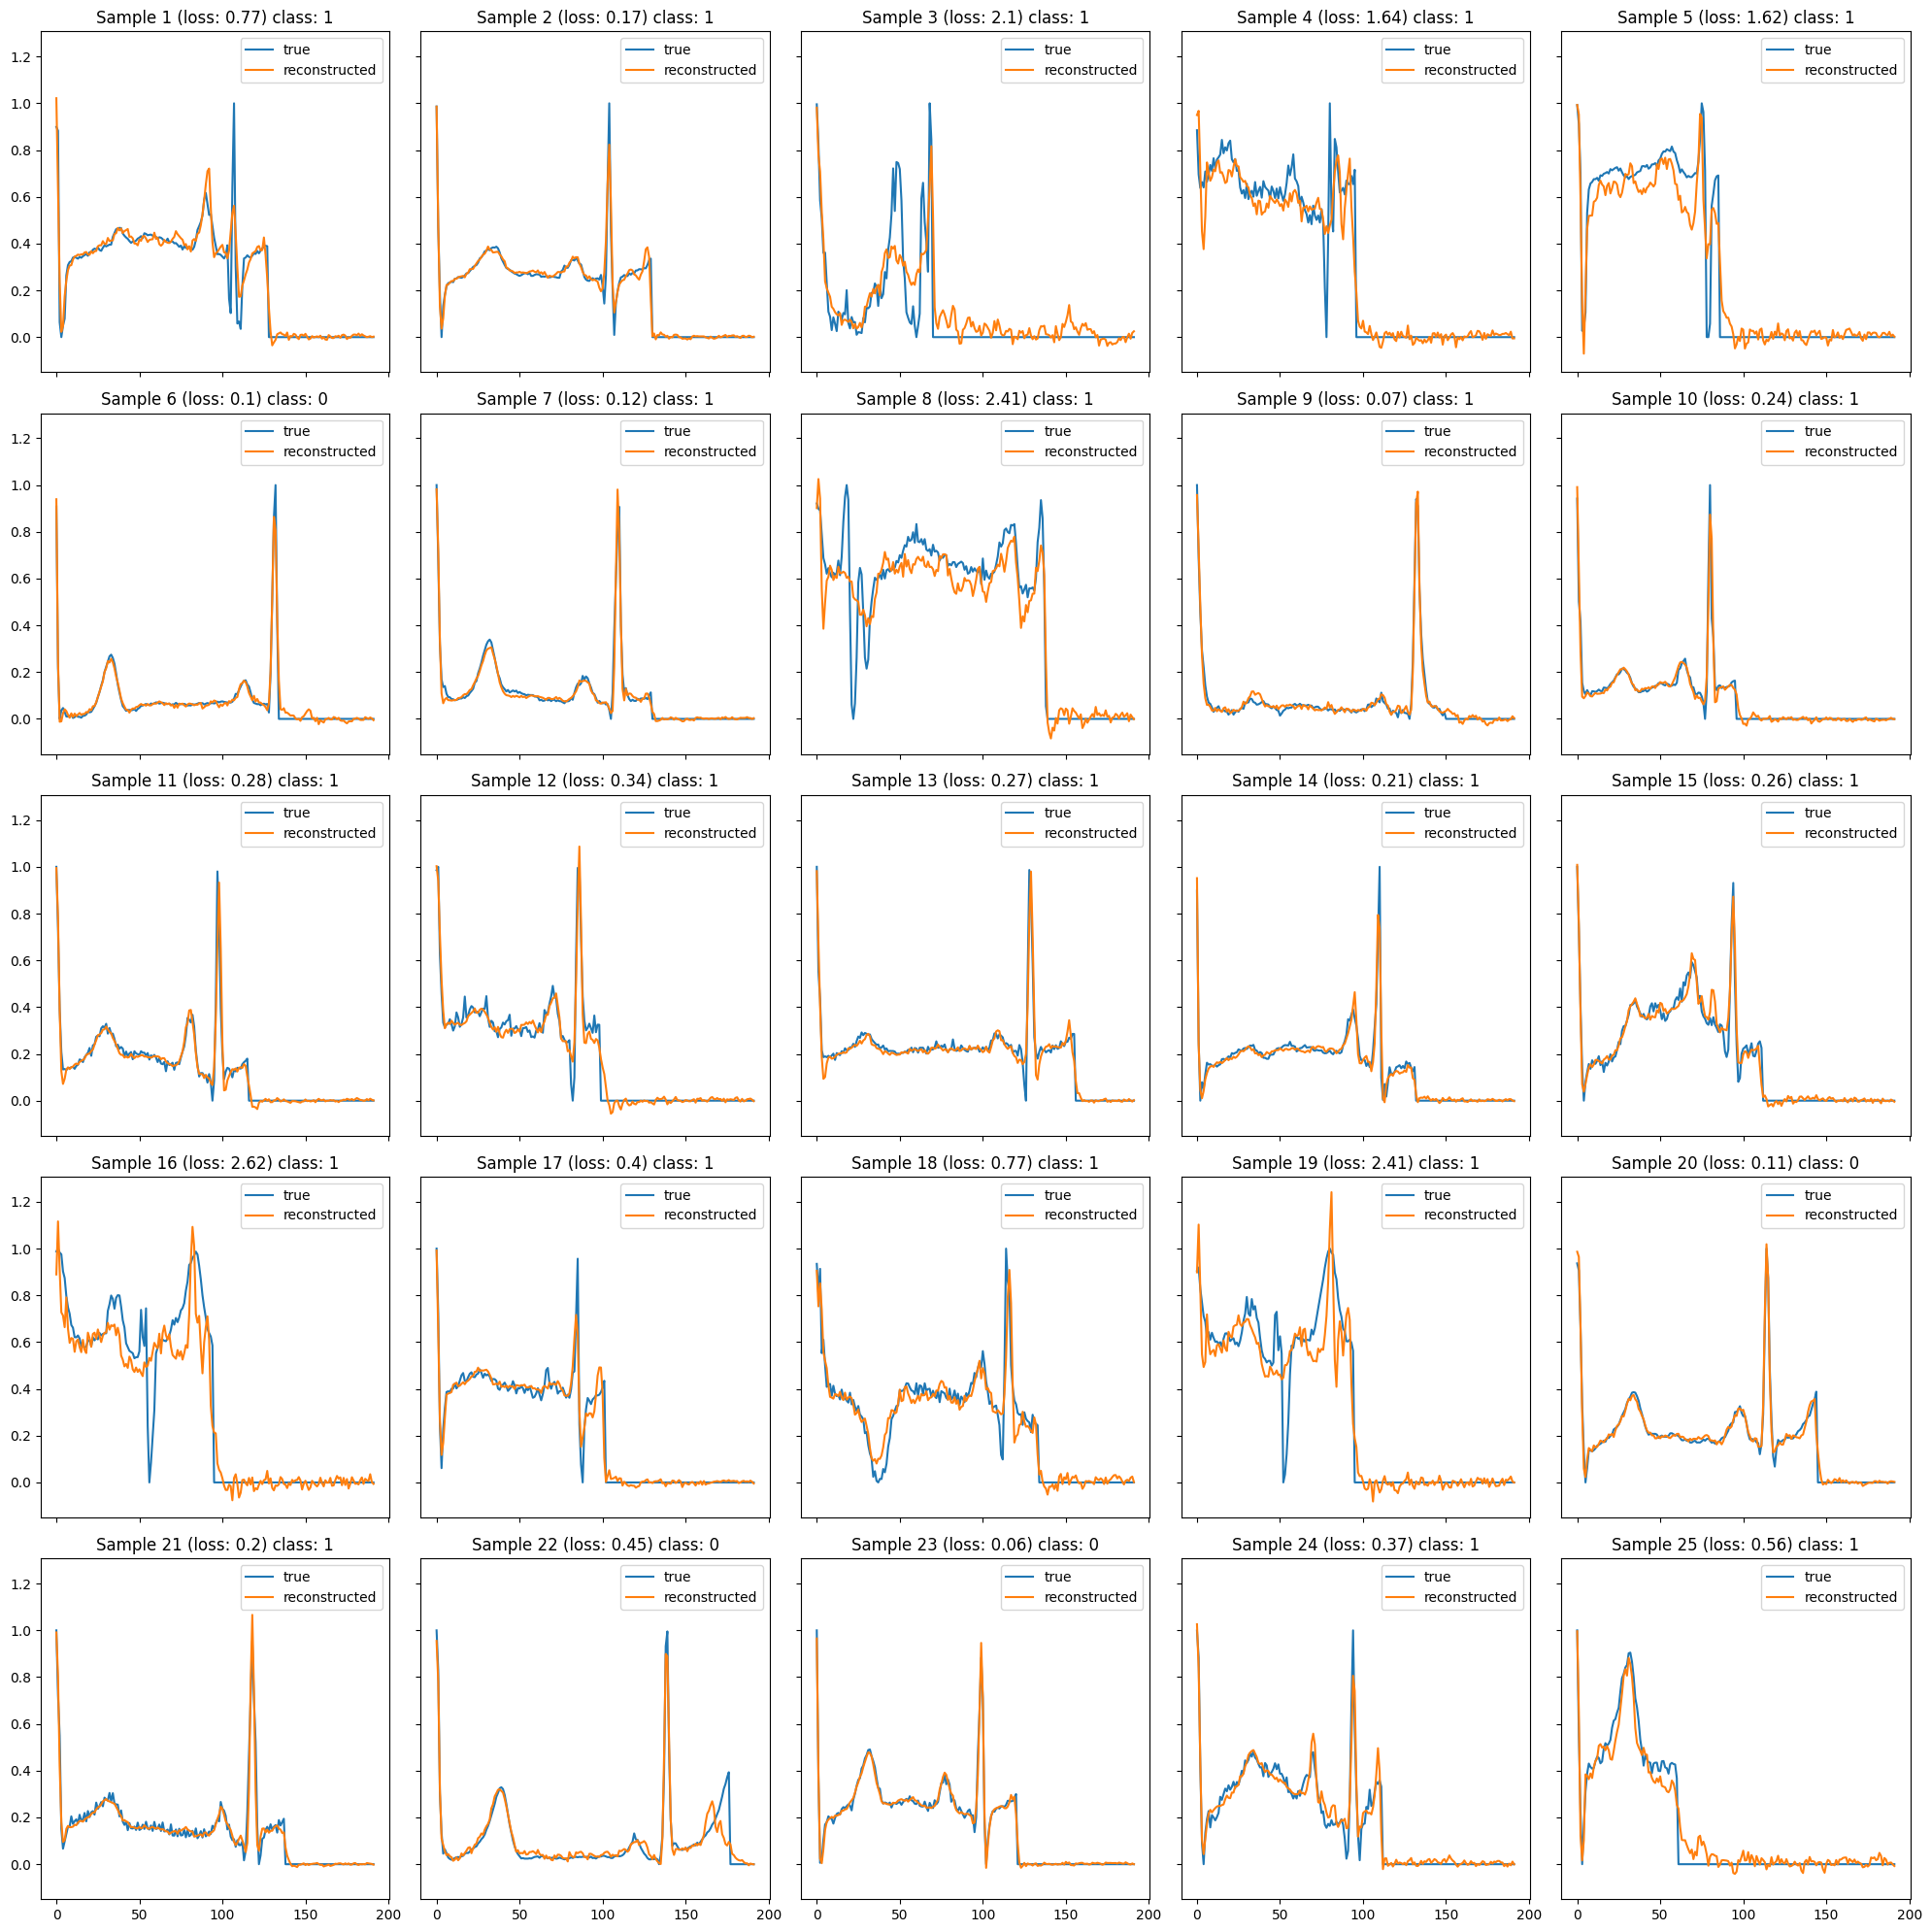

In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def predict(autoencoder, dataset):
    predictions, losses = [], []
    criterion = rae_model.ReconstructionLoss()
    with torch.no_grad():
        autoencoder.eval()
        for input_sequence, target in dataset:
            # Ensure input_sequence has correct dimensions (batch_size, seq_len, n_features)
            input_sequence = input_sequence.unsqueeze(0).to(device)  # Add a dummy batch dimension

            seq_pred = autoencoder(input_sequence)
            loss = criterion(seq_pred, input_sequence.squeeze(0))  # Use input_sequence for calculating loss
            
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses

def plot_prediction(data, autoencoder, title, ax):
    predictions, pred_losses = predict(autoencoder, [data])  # Pass encoder, decoder, and dataset
    
    input_sequence, target = data  # Extract input_sequence from the tuple
    data_np = input_sequence.cpu().numpy().flatten()  # Convert to NumPy array and flatten
    predictions_np = predictions[0].flatten()  # Flatten predictions
    
    ax.plot(data_np, label='true')
    ax.plot(predictions_np, label='reconstructed')
    ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)}) class: {target.item()}')
    ax.legend()

# Assuming validsdatasetVAE is your dataset of sequences
fig, axs = plt.subplots(
    nrows=5,  # 5 rows of plots
    ncols=5,  # 5 columns of plots
    sharey=True,
    sharex=True,
    figsize=(20, 20)  # Larger figure size for better readability
)

num_samples = 25  # Total number of samples to plot
random_indices = random.sample(range(len(validsdatasetVAE)), num_samples)

# Collect the samples
samples = [validsdatasetVAE[idx] for idx in random_indices]

for i, data in enumerate(samples):
    plot_prediction(data, autoencoder, title=f'Sample {i+1}', ax=axs[i // 5, i % 5])  # Pass encoder and decoder
  
fig.tight_layout()
plt.show()


After trying and changing layers and tweaking paramaters for days, I give up!
The autoencoder, sees a lot of abnormal heart rates as normal heart rates as shown in the above figures.
I squeezed the latent space to the most narrow variant and still no luck. I think to make it work, some way of penalizing the model for making reconstruction errors hard by abnormal heart rates.
Probably this could be done, by making it a supervised learning algorithm and using the actual label for penalizing the model harder.

Taking time in consideration, I quit this way and take another one.

Because of all the hours I put in this piece of art, I still keep the code (maybe for the next generation) and reference to it in the paper.
Maybe it will work some day.